In [57]:
import sys

!{sys.executable} -m pip install matplotlib opencv-python 
import os
import sys
import shutil  
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage import measure




[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
DATASET_PATH = "stage1_train"

In [59]:
def load_data(image_id):
    
    image_path = os.path.join(DATASET_PATH, image_id, "images")
    mask_path  = os.path.join(DATASET_PATH, image_id, "masks")
    
    
    image_file = os.listdir(image_path)[0]
    img = cv2.imread(os.path.join(image_path, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    mask_files = os.listdir(mask_path)
    
    combined_mask = None
    label = 1
    
    for file in mask_files:
        mask = cv2.imread(os.path.join(mask_path, file), 0)
        mask = (mask > 0).astype(np.uint8)
        
        if combined_mask is None:
            combined_mask = np.zeros_like(mask)
        
        combined_mask[mask == 1] = label
        label += 1
    
    return img, combined_mask

In [60]:
def watershed_simple(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    _, thresh = cv2.threshold(gray, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
   
    thresh = 255 - thresh
    
    # forming peak
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    
    # taking peak as seed
    _, sure_fg = cv2.threshold(dist, 0.3*dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    
    markers = measure.label(sure_fg)
    markers = markers.astype(np.int32)
    
    
    markers = cv2.watershed(img, markers)
    
    return markers

In [61]:
def watershed_marker_controlled(img):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    _, thresh = cv2.threshold(gray, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
                               kernel, iterations=2)

    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 3)

    _, sure_fg = cv2.threshold(dist,
                               0.4*dist.max(),
                               255, 0)

    sure_fg = np.uint8(sure_fg)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    unknown = cv2.subtract(sure_bg, sure_fg)

    # Label markers
    markers = measure.label(sure_fg)

    
    markers = markers.astype(np.int32)
    markers = np.ascontiguousarray(markers)

    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img, markers)

    return markers

In [62]:
def compute_dice(pred_markers, gt_mask):
    
    pred_binary = (pred_markers > 1).astype(np.uint8)
    gt_binary   = (gt_mask > 0).astype(np.uint8)
    
    intersection = np.sum(pred_binary * gt_binary)
    
    dice = (2. * intersection) / \
           (np.sum(pred_binary) + np.sum(gt_binary) + 1e-8)
    
    return dice


Image: 003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
Simple Watershed Dice: 0.11484334181650771
Marker Watershed Dice: 0.8794896030235355


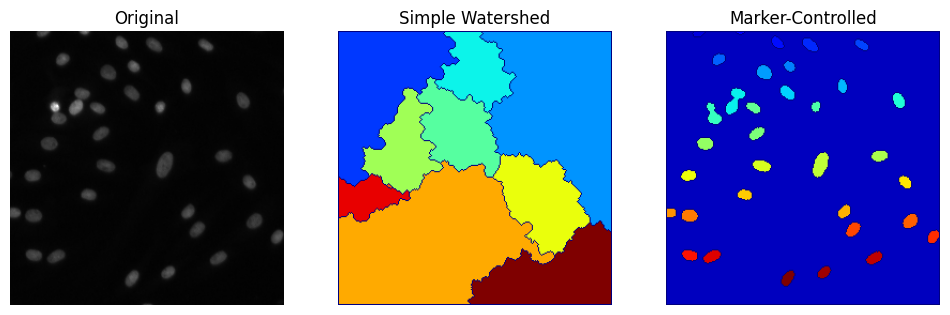


Image: 0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21
Simple Watershed Dice: 0.08363742519338208
Marker Watershed Dice: 0.9115155883926627


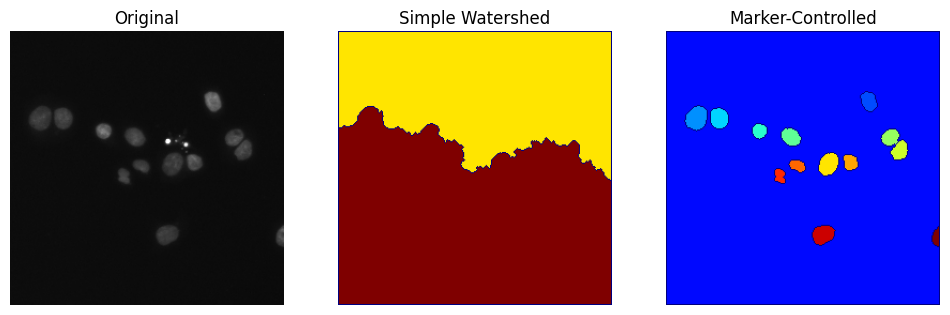


Image: 0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426
Simple Watershed Dice: 0.4488494907581198
Marker Watershed Dice: 0.6561099000531995


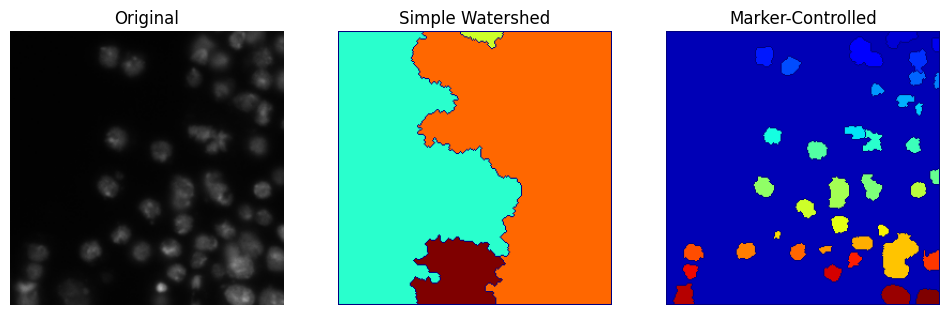


Image: 02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339
Simple Watershed Dice: 0.40740006082963676
Marker Watershed Dice: 0.8974939924474945


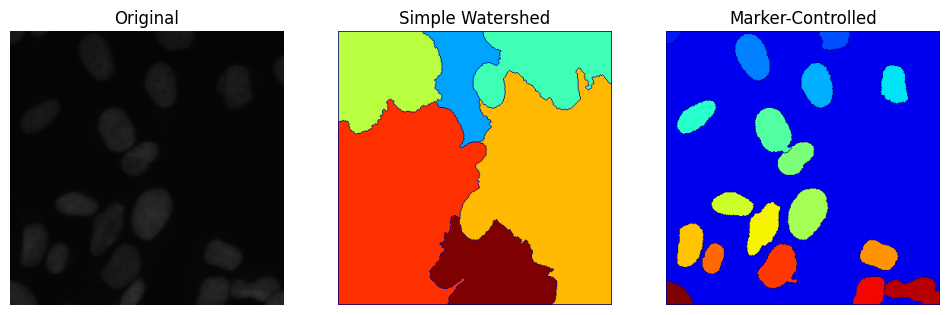


Image: 03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776
Simple Watershed Dice: 0.03455624204699978
Marker Watershed Dice: 0.7847857486721965


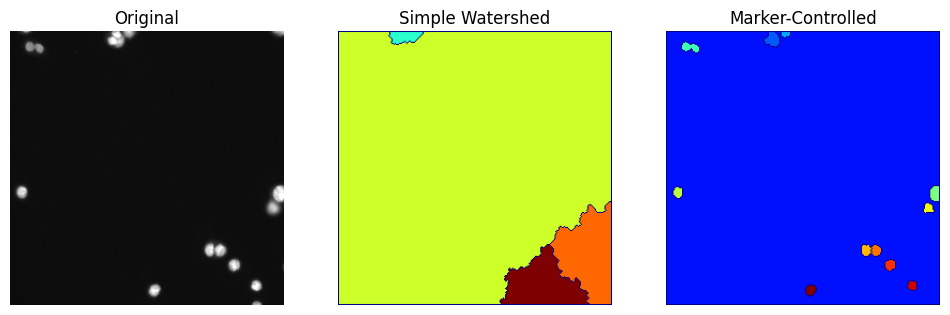

In [63]:
image_ids = os.listdir(DATASET_PATH)[:5]

for image_id in image_ids:
    
    img, gt = load_data(image_id)
    
    simple_ws = watershed_simple(img)
    marker_ws = watershed_marker_controlled(img)
    
    dice_simple = compute_dice(simple_ws, gt)
    dice_marker = compute_dice(marker_ws, gt)
    
    print(f"\nImage: {image_id}")
    print("Simple Watershed Dice:", dice_simple)
    print("Marker Watershed Dice:", dice_marker)
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.imshow(simple_ws, cmap='jet')
    plt.title("Simple Watershed")
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.imshow(marker_ws, cmap='jet')
    plt.title("Marker-Controlled")
    plt.axis("off")
    
    plt.show()